In [ ]:
%matplotlib inline

# Configuración del entorno

* Se utilizará Pytorch
* Se descargará el dataset "Yoga Poses Dataset" de Kaggle: https://www.kaggle.com/datasets/niharika41298/yoga-poses-dataset, posteriormente se lo subirá a Google Drive para poder ser manipulado dentro de Colab.
* Importa las bibliotecas necesarias, incluyendo torch, torchvision, y las bibliotecas de manipulación de imágenes.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from PIL import Image
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.layers import Input, Lambda, Dense, Flatten
from keras.applications import DenseNet121
from keras import regularizers
from keras.optimizers import Adam

# Preparación de los datos

* Utiliza las clases torchvision.datasets.ImageFolder y torchvision.transforms para cargar y transformar los datos de entrenamiento y prueba.
* Divide los datos de entrenamiento en un conjunto de entrenamiento y un conjunto de validación utilizando la función random_split de PyTorch.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = '/content/drive/MyDrive/Dataset-Yoga-2'

# Aumento de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.2
)

# Escalado para el conjunto de validación
test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Tamaño de lote
batch_size = 32

# Generador para el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    subset='training'
)

# Generador para el conjunto de validación
validation_generator = test_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation'
)


Found 380 images belonging to 4 classes.
Found 92 images belonging to 4 classes.


# DENSENET121

## Carga del modelo preentrenado
* Cargar un modelo preentrenado resnet18 de la familia de modelos de torchvision
* Congelar los parámetros del modelo preentrenado para evitar que se actualicen durante el proceso de entrenamiento.
* Reemplaza el clasificador existente del modelo preentrenado con un nuevo clasificador adecuado para la tarea de clasificación de Yoga Poses Dataset.
* Ajusta el número de neuronas de la capa de salida para que coincida con el número de clases en Yoga Poses Dataset.

In [ ]:
# Paso 1: Cargar modelo DenseNet121
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Paso 2: Congelar las capas existentes
for layer in base_model.layers:
    layer.trainable = False

# Paso 3: Agregar la nueva capa de salida para 4 clases
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Agregar una capa de Global Average Pooling
x = Dense(1024, activation='relu')(x)  # Agregar una capa densa con 1024 neuronas
predictions = Dense(4, activation='softmax')(x)  # Capa de salida con 5 neuronas (clasificación de 5 clases)

# Paso 4: Crear el nuevo modelo combinando DenseNet121 con la nueva capa de salida
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
optimizer = Adam(lr=0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])

epochs = 50

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

## Entrenamiento del modelo

* Utiliza un optimizador, por ejemplo, torch.optim.SGD, para optimizar los parámetros del clasificador.
* Entrena el modelo en el conjunto de entrenamiento utilizando un bucle de entrenamiento, actualizando los pesos del clasificador.
* Calcula la precisión del modelo en el conjunto de validación después de cada época para realizar un seguimiento del rendimiento.

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

history = model.fit(train_generator, epochs = epochs, batch_size=batch_size,validation_data = validation_generator)

Epoch 1/50
 3/12 [======>.......................] - ETA: 12s - loss: 1.6913 - accuracy: 0.2292

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


12/12 [==============================] - 59s 4s/step - loss: 1.5234 - accuracy: 0.3079 - val_loss: 1.3694 - val_accuracy: 0.3261
Epoch 2/50
12/12 [==============================] - 10s 818ms/step - loss: 1.4006 - accuracy: 0.3289 - val_loss: 1.2732 - val_accuracy: 0.3804
Epoch 3/50
12/12 [==============================] - 9s 702ms/step - loss: 1.3237 - accuracy: 0.3921 - val_loss: 1.2156 - val_accuracy: 0.4239
Epoch 4/50
12/12 [==============================] - 10s 821ms/step - loss: 1.2474 - accuracy: 0.4237 - val_loss: 1.1670 - val_accuracy: 0.4348
Epoch 5/50
12/12 [==============================] - 10s 801ms/step - loss: 1.1978 - accuracy: 0.4789 - val_loss: 1.1183 - val_accuracy: 0.4783
Epoch 6/50
12/12 [==============================] - 9s 725ms/step - loss: 1.1398 - accuracy: 0.5711 - val_loss: 1.0730 - val_accuracy: 0.5326
Epoch 7/50
12/12 [==============================] - 10s 815ms/step - loss: 1.0976 - accuracy: 0.5553 - val_loss: 1.0298 - val_accuracy: 0.5870
Epoch 8/50
12/1

## Evaluación del modelo

* Evalúa el rendimiento final del modelo utilizando el conjunto de prueba.
* Calcula la precisión y la pérdida promedio del modelo en el conjunto de prueba

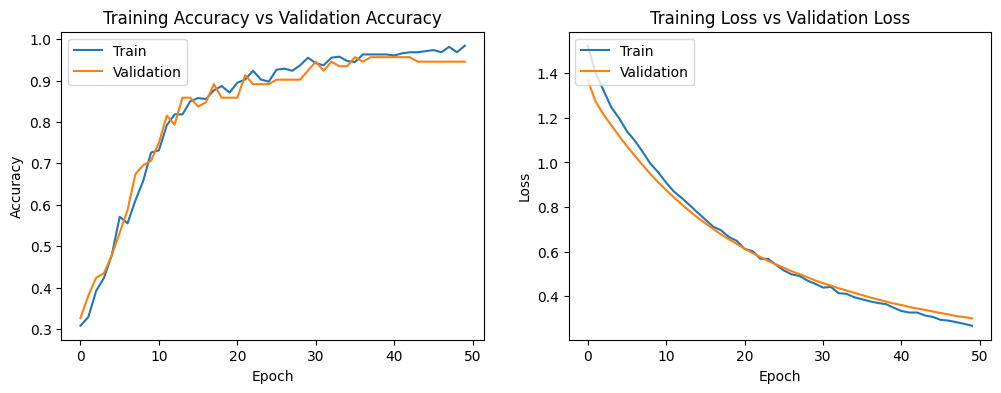

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("Presición del Entrenamiento = {:.2f}% , Presición de la Validación = {:.2f}%".format(train_acc*100, test_acc*100))

3/3 [==============================] - 1s 285ms/step - loss: 0.3007 - accuracy: 0.9457
Presición del Entrenamiento = 97.37% , Presición de la Validación = 94.57%


3/3 [==============================] - 4s 425ms/step


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


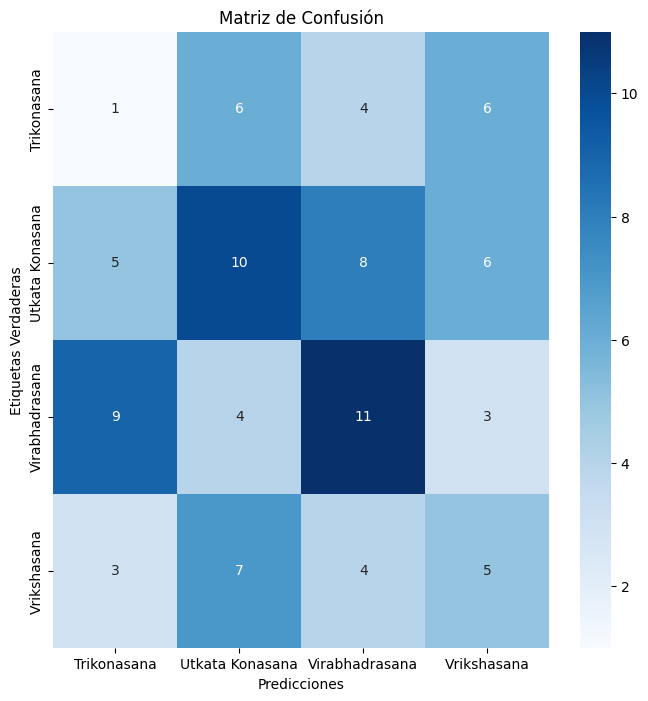

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obtener las predicciones del modelo en el conjunto de validación
validation_generator.reset()
predictions = model.predict(validation_generator, verbose=1)
y_true = validation_generator.classes
y_pred = np.argmax(predictions, axis=1)

# Calcular la matriz de confusión
confusion_mat = confusion_matrix(y_true, y_pred)

# Obtener los nombres de las clases
class_names = list(validation_generator.class_indices.keys())

# Graficar la matriz de confusión
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión")
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Verdaderas")
plt.show()


## Guardar Modelo

In [ ]:
model.save('densenet121_yoga.h5')